In [1]:
import csv
import sys
import os
import glob
import gzip
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set()
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

# DA sys data

In [2]:
WMT19_ROOT = '../'
da_sys = pd.read_csv(os.path.join(WMT19_ROOT, 'manual-evaluation/DA-syslevel.csv'), delimiter=' ', header=0)
da_sys.columns = ['lp', 'DA', 'system']

In [3]:
print(len(da_sys))
da_sys.head()

225


,lp,DA,system
0,en-cs,0.402,CUNI-DocTransformer-T2T.6751
1,en-cs,0.401,CUNI-Transformer-T2T-2018.6457
2,en-cs,0.388,CUNI-Transformer-T2T-2019.6851
3,en-cs,0.223,CUNI-DocTransformer-Marian.6922
4,en-cs,0.206,uedin.6667


# DA seg data

In [4]:
da_seg = pd.read_csv(os.path.join(WMT19_ROOT, 'manual-evaluation/RR-seglevel.csv'), delimiter=' ', header=0)
da_seg.columns = ['lp', 'testset', 'segid', 'better', 'worse']

In [5]:
print(len(da_seg))
da_seg.head()

571791


,lp,testset,segid,better,worse
0,de-en,newstest2019,1718,uedin.6749,online-A.0
1,de-en,newstest2019,1718,online-X.0,online-A.0
2,de-en,newstest2019,1718,online-X.0,online-G.0
3,de-en,newstest2019,1718,online-X.0,NEU.6801
4,de-en,newstest2019,1718,JHU.6809,online-A.0


# seg-level data

### seg-level submissions

In [6]:
seg_scores = pd.DataFrame.from_dict({'lp':[], 'testset':[], 'docid':[], 'system':[], 'segid':[]})

for i, submission in enumerate(glob.glob(os.path.join(WMT19_ROOT, 'final-metric-scores/submissions-corrected/*.seg.score.gz'))):
    submission_scores = pd.read_csv(gzip.open(submission, 'rt'), header=None, delimiter='\t')
    name = submission_scores[0].unique()[0]
    print('Metric: %s' % name)
    
    submission_scores = submission_scores.drop([0, 7, 8], axis=1)
    submission_scores.columns = ['lp', 'testset', 'docid', 'system', 'segid', name]

    seg_scores = pd.merge(seg_scores, submission_scores, on=['lp', 'testset', 'docid', 'system', 'segid'], how='outer')

Metric: YiSi-2_srl
Metric: LASIM
Metric: BERTr
Metric: UNI+
Metric: YiSi-1
Metric: Meteor++_2.0(syntax)
Metric: YiSi-0
Metric: USFD
Metric: CharacTER
Metric: YiSi-2
Metric: LP
Metric: ESIM
Metric: BEER
Metric: EED
Metric: WMDO
Metric: ibm1-pos4gram
Metric: YiSi-1_srl
Metric: USFD-TL
Metric: PReP
Metric: ibm1-morpheme
Metric: Meteor++_2.0(syntax+copy)
Metric: hLEPORa_baseline
Metric: UNI


### seg-level baselines

In [24]:
seg_baseline_scores = pd.DataFrame.from_dict({'lp':[], 'testset':[], 'docid':[], 'system':[], 'segid':[]})

for i, baseline in enumerate(glob.glob(os.path.join(WMT19_ROOT, 'baselines/sentBLEU.seg.score.gz'))):
    submission_scores = pd.read_csv(gzip.open(baseline, 'rt'), header=None, delimiter='\t')
    name = submission_scores[0].unique()[0]
    print('Metric: %s' % name)
    
    submission_scores = submission_scores.drop([0], axis=1)
    # when baselines have docids
    submission_scores.columns = ['lp', 'testset', 'docid', 'system', 'segid', name]

    seg_baseline_scores = pd.merge(seg_baseline_scores, submission_scores, on=['lp', 'testset', 'system', 'docid', 'segid'], how='outer')

In [8]:
#seg_all_scores = pd.merge(seg_scores, seg_baseline_scores, on=['lp', 'testset', 'system', 'docid', 'segid'], how='outer')
seg_all_scores = seg_scores
assert(len(seg_all_scores[seg_all_scores.docid.isna()]) == 0)

In [9]:
# remove testsuites
seg_all_scores_nots = seg_all_scores[~seg_all_scores.docid.str.contains('testsuite')]
print('# of instances: %d, without testsuites: %d' % (len(seg_all_scores), len(seg_all_scores_nots)))

# remove "NO REFERENCE AVAILABLE"
# TODO

# of instances: 1369527, without testsuites: 485110


# sys-level data

### sys-level submissions that are averages

In [40]:
# sys_scores = seg_all_scores_nots.groupby(['lp','system']).agg(lambda g: g.mean(skipna=False))
# sys_scores.head()

sys_scores = pd.DataFrame.from_dict({'lp':[], 'testset':[], 'system':[]})

for i, submission in enumerate(glob.glob(os.path.join(WMT19_ROOT, 'final-metric-scores/submissions-corrected/*.sys.score.gz'))):
    submission_scores = pd.read_csv(gzip.open(submission, 'rt'), header=None, delimiter=' ')
    name = submission_scores[0].unique()[0]
    print('Metric: %s' % name)
    # print(submission_scores.iloc[0])

    submission_scores = submission_scores.drop([0, 5, 6], axis=1)
    submission_scores.columns = ['lp', 'testset', 'system', name]

    sys_scores = pd.merge(sys_scores, submission_scores, on=['lp', 'testset', 'system'], how='outer')

Metric: LP
Metric: CharacTER
Metric: YiSi-2
Metric: ibm1-pos4gram
Metric: WMDO
Metric: BEER
Metric: ESIM
Metric: EED
Metric: ibm1-morpheme
Metric: hLEPORa_baseline
Metric: BERT-P
Metric: Meteor++_2.0(syntax+copy)
Metric: PReP
Metric: USFD-TL
Metric: BERT-F1
Metric: YiSi-1_srl
Metric: UNI
Metric: hLEPORb_baseline
Metric: YiSi-2_srl
Metric: BERT-R
Metric: LASIM
Metric: YiSi-1
Metric: UNI+
Metric: BERTr
Metric: USFD
Metric: YiSi-0
Metric: Meteor++_2.0(syntax)


### sys-level submissions

In [41]:
submission_scores = pd.read_csv(gzip.open(os.path.join(WMT19_ROOT, 'final-metric-scores/submissions-corrected/LEPORb.sys.score.gz'), 'rt'), header=None, delimiter=' ')
name = submission_scores[0].unique()[0]
print('Metric: %s' % name)

sys_submission_scores = submission_scores.drop([0, 5, 6], axis=1)
sys_submission_scores.columns = ['lp', 'testset', 'system', 'LEPORb']

Metric: hLEPORb_baseline


In [42]:
submission_scores = pd.read_csv(gzip.open(os.path.join(WMT19_ROOT, 'final-metric-scores/submissions-corrected/BERT-F1.sys.score.gz'), 'rt'), header=None, delimiter=' ')
name = submission_scores[0].unique()[0]
print('Metric: %s' % name)

sys_submission_scores = submission_scores.drop([0, 5, 6], axis=1)
sys_submission_scores.columns = ['lp', 'testset', 'system', 'LEPORb']

Metric: BERT-F1


### sys-level baselines

In [43]:
sys_baseline_scores = pd.DataFrame.from_dict({'lp':[], 'testset':[], 'system':[]})

for i, baseline in enumerate(glob.glob(os.path.join(WMT19_ROOT, 'baselines/*.sys.score.gz'))):
    submission_scores = pd.read_csv(gzip.open(baseline, 'rt'), header=None, delimiter='\t')
    
    for name in submission_scores[0].unique():
        print('Metric: %s' % name)
        name_submission_scores = submission_scores[submission_scores[0] == name].drop([0], axis=1)
        name_submission_scores.columns = ['lp', 'testset', 'system', name]
        
        #drop hybrids from qingsongs files
        name_submission_scores = name_submission_scores[~name_submission_scores.system.str.contains('hybrid')]
        
        sys_baseline_scores = pd.merge(sys_baseline_scores, name_submission_scores, on=['lp', 'testset', 'system'], how='outer')

Metric: TER
Metric: sacreBLEU-BLEU
Metric: WER
Metric: PER
Metric: CDER
Metric: chrF+
Metric: sacreBLEU-chrF
Metric: chrF
Metric: NIST
Metric: BLEU


In [44]:
sys_baseline_scores.head()

,lp,testset,system,TER,sacreBLEU-BLEU,WER,PER,CDER,chrF+,sacreBLEU-chrF,chrF,NIST,BLEU
0,cs-de,newstest2019,NEU_KingSoft.6783,0.3086,0.1867,0.2819,0.4816,0.3804,48.4078,49.0992,48.2633,4.8260,0.1376
1,cs-de,newstest2019,NICT.6948,0.3186,0.2008,0.2920,0.4919,0.3950,50.0038,50.9079,49.7396,5.0419,0.1495
2,cs-de,newstest2019,online-A.0,0.3507,0.2248,0.3237,0.5333,0.4106,50.9467,51.8920,50.7529,5.5975,0.1785
3,cs-de,newstest2019,online-B.0,0.3823,0.2348,0.3570,0.5298,0.4215,51.2481,51.8939,51.0832,6.0876,0.1990
4,cs-de,newstest2019,online-G.0,0.3618,0.2380,0.3362,0.5226,0.4082,50.9688,51.3502,50.9056,5.8784,0.1925


In [45]:
sys_baseline_scores.iloc[0]

lp                            cs-de
testset                newstest2019
system            NEU_KingSoft.6783
TER                          0.3086
sacreBLEU-BLEU               0.1867
WER                          0.2819
PER                          0.4816
CDER                         0.3804
chrF+                       48.4078
sacreBLEU-chrF              49.0992
chrF                        48.2633
NIST                          4.826
BLEU                         0.1376
Name: 0, dtype: object

In [48]:
sys_all_scores = pd.merge(sys_scores, sys_baseline_scores, on=['lp', 'system'])
# sys_all_scores = pd.merge(sys_all_scores, sys_submission_scores, on=['lp', 'system', 'testset'], how='outer')
sys_all_scores.head()

,lp,testset_x,system,LP,CharacTER,YiSi-2,ibm1-pos4gram,WMDO,BEER,ESIM,EED,ibm1-morpheme,hLEPORa_baseline,BERT-P,Meteor++_2.0(syntax+copy),PReP,USFD-TL,BERT-F1,YiSi-1_srl,UNI,hLEPORb_baseline,YiSi-2_srl,BERT-R,LASIM,YiSi-1,UNI+,BERTr,USFD,YiSi-0,Meteor++_2.0(syntax),testset_y,TER,sacreBLEU-BLEU,WER,PER,CDER,chrF+,sacreBLEU-chrF,chrF,NIST,BLEU
0,en-ru,newstest2019,Facebook_FAIR.6724,2.911780,-0.403882,0.765788,NaN,NaN,0.617155,0.634558,-0.312485,NaN,NaN,NaN,NaN,NaN,0.318807,NaN,NaN,0.498815,NaN,NaN,NaN,0.914633,0.882528,0.522069,NaN,0.390115,0.708573,NaN,newstest2019,0.5267,0.3719,0.5118,0.6261,0.5682,70.1303,59.5507,71.3104,4.9576,0.2247
1,en-ru,newstest2019,rerank-er.6572,2.851313,-0.503067,0.781467,NaN,NaN,0.524606,0.463919,-0.386967,NaN,NaN,NaN,NaN,NaN,0.306472,NaN,NaN,0.493268,NaN,NaN,NaN,0.922521,0.853831,0.516478,NaN,0.374542,0.631578,NaN,newstest2019,0.4390,0.2856,0.4245,0.5411,0.4825,62.1776,51.3483,63.3983,4.1289,0.1734
2,en-ru,newstest2019,online-X.0,2.943585,-0.507949,0.755321,NaN,NaN,0.542877,0.416660,-0.391756,NaN,NaN,NaN,NaN,NaN,0.316153,NaN,NaN,0.484014,NaN,NaN,NaN,0.914990,0.835563,0.505519,NaN,0.379179,0.639726,NaN,newstest2019,0.4075,0.2643,0.3918,0.5272,0.4504,62.1492,49.3051,63.7110,4.1127,0.1593
3,en-ru,newstest2019,online-A.0,2.977824,-0.496624,0.763904,NaN,NaN,0.551624,0.408201,-0.384539,NaN,NaN,NaN,NaN,NaN,0.299649,NaN,NaN,0.480711,NaN,NaN,NaN,0.921031,0.846006,0.500487,NaN,0.363495,0.641842,NaN,newstest2019,0.4227,0.2459,0.4097,0.5156,0.4556,63.2247,50.5605,65.0094,4.0337,0.1538
4,en-ru,newstest2019,online-B.0,3.194020,-0.434386,0.763823,NaN,NaN,0.597253,0.588469,-0.340526,NaN,NaN,NaN,NaN,NaN,0.302152,NaN,NaN,0.491323,NaN,NaN,NaN,0.912305,0.871469,0.513357,NaN,0.380948,0.686043,NaN,newstest2019,0.4951,0.3202,0.4811,0.5769,0.5283,67.3174,56.4801,68.8301,4.7574,0.2036


# checks

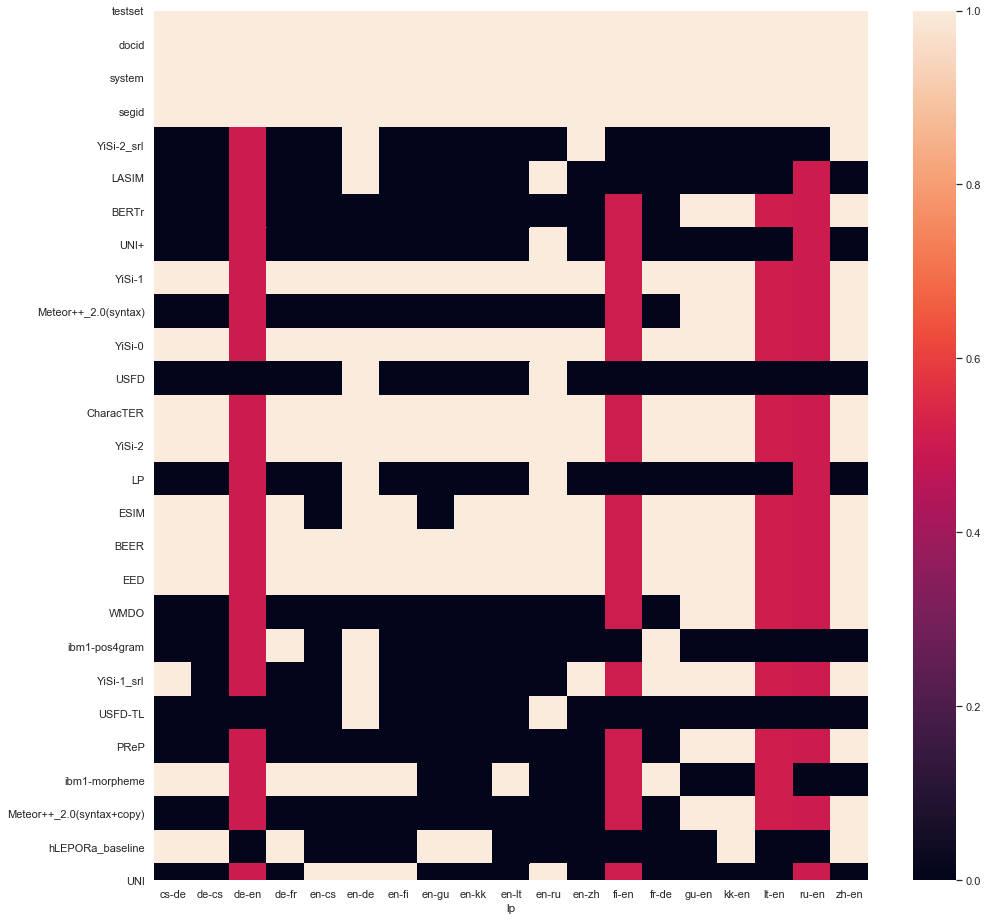

In [49]:
# segment level checks
counts = seg_all_scores_nots.groupby('lp').count().T
counts = (counts / counts.max())
sns.set()
plt.figure(figsize=(16,16))
sns.heatmap(counts)

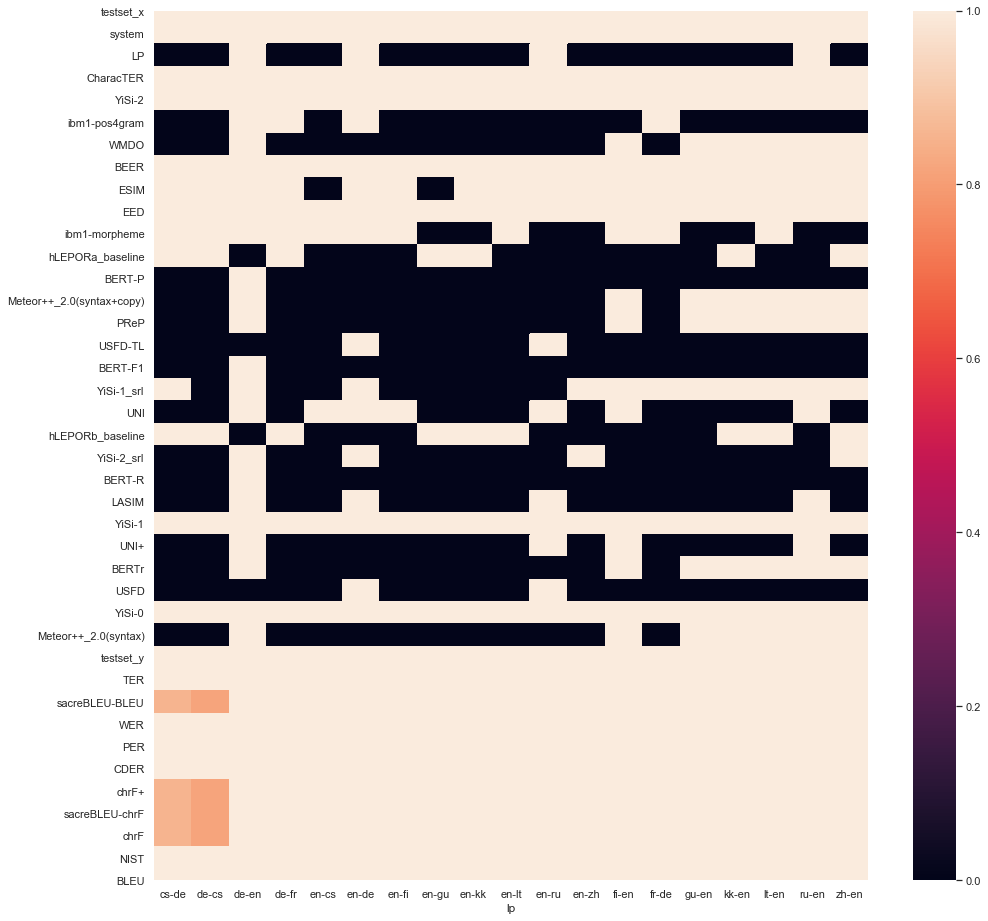

In [50]:
# segment level checks
counts = sys_all_scores.groupby('lp').count().T
counts = (counts / counts.max())
sns.set()
plt.figure(figsize=(16,16))
sns.heatmap(counts)

# sys-level correlations

In [51]:
df = pd.merge(da_sys, sys_all_scores, on=['lp', 'system'], how='outer')

# partial results if da_sys has na
df = df[df.DA.notna()]
df

,lp,DA,system,testset_x,LP,CharacTER,YiSi-2,ibm1-pos4gram,WMDO,BEER,ESIM,EED,ibm1-morpheme,hLEPORa_baseline,BERT-P,Meteor++_2.0(syntax+copy),PReP,USFD-TL,BERT-F1,YiSi-1_srl,UNI,hLEPORb_baseline,YiSi-2_srl,BERT-R,LASIM,YiSi-1,UNI+,BERTr,USFD,YiSi-0,Meteor++_2.0(syntax),testset_y,TER,sacreBLEU-BLEU,WER,PER,CDER,chrF+,sacreBLEU-chrF,chrF,NIST,BLEU
0,en-cs,0.402,CUNI-DocTransformer-T2T.6751,newstest2019,NaN,-0.473012,0.764996,NaN,NaN,0.587546,NaN,-0.358870,-538834.399788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.451509,NaN,NaN,NaN,NaN,0.865066,NaN,NaN,NaN,0.647281,NaN,newstest2019,0.4697,0.3103,0.4427,0.6061,0.5042,57.7576,56.1449,57.5673,5.1045,0.1904
1,en-cs,0.401,CUNI-Transformer-T2T-2018.6457,newstest2019,NaN,-0.472164,0.763242,NaN,NaN,0.586932,NaN,-0.360134,-527818.114977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.451607,NaN,NaN,NaN,NaN,0.865321,NaN,NaN,NaN,0.647019,NaN,newstest2019,0.4714,0.3093,0.4452,0.6037,0.5042,57.5857,56.1830,57.4147,5.2036,0.1968
2,en-cs,0.388,CUNI-Transformer-T2T-2019.6851,newstest2019,NaN,-0.484397,0.763402,NaN,NaN,0.579734,NaN,-0.368192,-536831.475870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449209,NaN,NaN,NaN,NaN,0.860957,NaN,NaN,NaN,0.639329,NaN,newstest2019,0.4647,0.3042,0.4386,0.5971,0.4977,56.5415,55.3537,56.3307,5.0849,0.1892
3,en-cs,0.223,CUNI-DocTransformer-Marian.6922,newstest2019,NaN,-0.490662,0.761952,NaN,NaN,0.574024,NaN,-0.372733,-522309.622032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449402,NaN,NaN,NaN,NaN,0.858328,NaN,NaN,NaN,0.633046,NaN,newstest2019,0.4513,0.2917,0.4243,0.5878,0.4877,55.9912,54.5194,55.8463,4.8610,0.1769
4,en-cs,0.206,uedin.6667,newstest2019,NaN,-0.486119,0.763326,NaN,NaN,0.576676,NaN,-0.370773,-542339.781808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450413,NaN,NaN,NaN,NaN,0.861178,NaN,NaN,NaN,0.635241,NaN,newstest2019,0.4589,0.2900,0.4323,0.5877,0.4895,56.1944,55.0079,56.0571,5.1417,0.1916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,de-fr,0.019,online-Y.0,newstest2019,NaN,-0.428500,0.786971,-1.967702e+06,NaN,0.614043,0.599131,-0.325419,-207546.179706,0.681387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.681387,NaN,NaN,NaN,0.876079,NaN,NaN,NaN,0.691036,NaN,newstest2019,0.4936,0.3641,0.4665,0.6065,0.5197,59.5579,61.0422,59.5731,8.3309,0.3641
221,de-fr,-0.104,TartuNLP-c.6897,newstest2019,NaN,-0.445475,0.794167,-1.895391e+06,NaN,0.609343,0.561340,-0.332246,-225182.682574,0.665888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.665888,NaN,NaN,NaN,0.872103,NaN,NaN,NaN,0.681943,NaN,newstest2019,0.4629,0.3415,0.4348,0.5908,0.4967,58.9623,59.6902,58.8240,7.9147,0.3415
222,de-fr,-0.194,online-A.0,newstest2019,NaN,-0.454312,0.783866,-2.244600e+06,NaN,0.600173,0.548084,-0.340565,-184030.375535,0.654322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.654322,NaN,NaN,NaN,0.866127,NaN,NaN,NaN,0.673071,NaN,newstest2019,0.4508,0.3515,0.4212,0.6134,0.5002,58.8795,59.4449,58.9674,7.9717,0.3515
223,de-fr,-0.240,online-G.0,newstest2019,NaN,-0.480254,0.778213,-2.195806e+06,NaN,0.585731,0.537749,-0.348079,-202255.942536,0.640371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.640371,NaN,NaN,NaN,0.856651,NaN,NaN,NaN,0.672808,NaN,newstest2019,0.4308,0.3412,0.4067,0.5738,0.4724,56.5843,57.8387,56.6676,8.0219,0.3412


In [52]:
df[df.lp.str.endswith('en')].groupby('lp').corr().round(3)[::36].T

lp                         de-en                 fi-en  gu-en  kk-en  lt-en  \
                              DA   NIST sacreBLEU-chrF   CDER    WER    TER   
DA                         1.000  0.813          0.990  0.876  0.793  0.960   
LP                        -0.474 -0.466            NaN    NaN    NaN    NaN   
CharacTER                  0.898  0.906          0.989  0.976  0.730  0.994   
YiSi-2                     0.796  0.860          0.708 -0.150 -0.153  0.577   
ibm1-pos4gram             -0.339 -0.001            NaN    NaN    NaN    NaN   
WMDO                       0.872  0.898          0.980  0.904  0.780  0.980   
BEER                       0.906  0.930          0.996  0.956  0.834  0.993   
ESIM                       0.941  0.817          0.962  0.972  0.746  0.963   
EED                        0.903  0.901          0.997  0.942  0.715  0.988   
ibm1-morpheme             -0.345 -0.073          0.689    NaN    NaN  0.680   
hLEPORa_baseline             NaN    NaN            NaN    NaN  0.845    NaN   
BERT-P                     0.947  0.861            NaN    NaN    NaN    NaN   
Meteor++_2.0(syntax+copy)  0.896  0.910          0.992  0.906  0.742  0.983   
PReP                       0.575  0.475          0.587  0.974  0.738  0.471   
USFD-TL                      NaN    NaN            NaN    NaN    NaN    NaN   
BERT-F1                    0.949  0.859            NaN    NaN    NaN    NaN   
YiSi-1_srl                 0.950  0.872          0.991  0.978  0.757  0.990   
UNI                        0.846  0.626          0.925    NaN    NaN    NaN   
hLEPORb_baseline             NaN    NaN            NaN    NaN  0.845  0.983   
YiSi-2_srl                 0.804  0.856            NaN    NaN    NaN    NaN   
BERT-R                     0.946  0.854            NaN    NaN    NaN    NaN   
LASIM                      0.247  0.487            NaN    NaN    NaN    NaN   
YiSi-1                     0.949  0.874          0.991  0.975  0.758  0.991   
UNI+                       0.850  0.623          0.918    NaN    NaN    NaN   
BERTr                      0.926  0.849          0.984  0.979  0.734  0.996   
USFD                         NaN    NaN            NaN    NaN    NaN    NaN   
YiSi-0                     0.902  0.922          0.992  0.895  0.753  0.990   
Meteor++_2.0(syntax)       0.887  0.906          0.991  0.916  0.735  0.986   
TER                        0.874  0.938          0.988  0.982  0.999  1.000   
sacreBLEU-BLEU             0.813  0.922          0.986  0.993  0.881  0.983   
WER                        0.863  0.931          0.985  0.969  1.000  0.999   
PER                        0.883  0.935          0.993  0.964  0.984  0.979   
CDER                       0.890  0.911          0.991  1.000  0.740  0.992   
chrF+                      0.916  0.908          0.999  0.931  0.714  0.987   
sacreBLEU-chrF             0.910  0.916          1.000  0.889  0.714  0.982   
chrF                       0.917  0.911          0.999  0.921  0.716  0.987   
NIST                       0.813  1.000          0.985  0.976  0.907  0.991   
BLEU                       0.849  0.991          0.984  0.993  0.881  0.984   

lp                         ru-en  zh-en  
                          YiSi-0  BERTr  
DA                         0.958  0.974  
LP                        -0.501    NaN  
CharacTER                  0.988  0.989  
YiSi-2                    -0.331  0.952  
ibm1-pos4gram                NaN    NaN  
WMDO                       0.981  0.990  
BEER                       0.971  0.981  
ESIM                       0.945  0.993  
EED                        0.997  0.986  
ibm1-morpheme                NaN    NaN  
hLEPORa_baseline             NaN  0.992  
BERT-P                       NaN    NaN  
Meteor++_2.0(syntax+copy)  0.988  0.990  
PReP                       0.889  0.658  
USFD-TL                      NaN    NaN  
BERT-F1                      NaN    NaN  
YiSi-1_srl                 0.977  0.989  
UNI                        0.714    NaN  

In [53]:
df[df.lp.str.startswith('en')].groupby('lp').corr().round(3)[::36].T.dropna(how='all')

lp                en-cs                 en-de  en-fi  en-gu  en-kk  en-lt  \
                     DA   NIST sacreBLEU-chrF   CDER    WER    TER YiSi-0   
DA                1.000  0.896          0.976  0.978  0.861  0.940  0.974   
LP                  NaN    NaN         -0.482    NaN    NaN    NaN    NaN   
CharacTER         0.994  0.914          0.992  0.972  0.967  0.831  0.992   
YiSi-2            0.324  0.516          0.895  0.725  0.334  0.176  0.141   
ibm1-pos4gram       NaN    NaN          0.493    NaN    NaN    NaN    NaN   
BEER              0.990  0.937          0.994  0.987  0.962  0.954  0.997   
ESIM                NaN    NaN          0.975  0.963    NaN  0.987  0.981   
EED               0.993  0.922          0.996  0.983  0.967  0.946  0.996   
ibm1-morpheme    -0.871 -0.815          0.804  0.178    NaN    NaN -0.721   
hLEPORa_baseline    NaN    NaN            NaN    NaN  0.960  0.936    NaN   
USFD-TL             NaN    NaN         -0.147    NaN    NaN    NaN    NaN   
YiSi-1_srl          NaN    NaN          0.989    NaN    NaN    NaN    NaN   
UNI               0.028  0.077          0.766  0.933    NaN    NaN    NaN   
hLEPORb_baseline    NaN    NaN            NaN    NaN  0.960  0.936  0.983   
YiSi-2_srl          NaN    NaN          0.910    NaN    NaN    NaN    NaN   
LASIM               NaN    NaN          0.825    NaN    NaN    NaN    NaN   
YiSi-1            0.962  0.952          0.987  0.974  0.958  0.971  0.984   
USFD                NaN    NaN         -0.301    NaN    NaN    NaN    NaN   
YiSi-0            0.992  0.930          0.991  0.979  0.965  0.963  1.000   
TER               0.980  0.950          0.992  0.999  0.999  1.000  0.965   
sacreBLEU-BLEU    0.994  0.907          0.991  0.980  0.961  0.874  0.968   
WER               0.982  0.948          0.990  0.998  1.000  1.000  0.959   
PER               0.976  0.939          0.996  0.996  0.955  0.994  0.952   
CDER              0.985  0.931          0.997  1.000  0.972  0.952  0.971   
chrF+             0.991  0.934          0.999  0.987  0.873  0.906  0.990   
sacreBLEU-chrF    0.983  0.946          1.000  0.982  0.941  0.922  0.993   
chrF              0.990  0.936          0.999  0.984  0.834  0.899  0.988   
NIST              0.896  1.000          0.319  0.972  0.968  0.953  0.977   
BLEU              0.897  0.999          0.933  0.978  0.961  0.874  0.966   

lp               en-ru  en-zh  
                 BERTr YiSi-1  
DA                 NaN  0.951  
LP                 NaN    NaN  
CharacTER          NaN  0.960  
YiSi-2             NaN  0.141  
ibm1-pos4gram      NaN    NaN  
BEER               NaN  0.918  
ESIM               NaN  0.994  
EED                NaN  0.957  
ibm1-morpheme      NaN    NaN  
hLEPORa_baseline   NaN    NaN  
USFD-TL            NaN    NaN  
YiSi-1_srl         NaN  1.000  
UNI                NaN    NaN  
hLEPORb_baseline   NaN    NaN  
YiSi-2_srl         NaN  0.117  
LASIM              NaN    NaN  
YiSi-1             NaN  1.000  
USFD               NaN    NaN  
YiSi-0             NaN  0.966  
TER                NaN  0.939  
sacreBLEU-BLEU     NaN  0.822  
WER                NaN  0.952  
PER                NaN  0.967  
CDER               NaN  0.981  
chrF+              NaN  0.968  
sacreBLEU-chrF     NaN  0.916  
chrF               NaN  0.971  
NIST               NaN  0.971  
BLEU               NaN  0.980

### william test parameters

In [55]:
metric_da_corrs = {}
metric_metric_corrs = {}
ns = {}

#TODO need to decide on the signs for some of
#the metrics, LP, ibm1-morpheme...

for lp in df['lp'].unique():
    print(lp)
    
    corr_matrix = df[df.lp == lp].corr().round(3)
    
    metrics = []
    metric_da_corr = []
    for row in corr_matrix['DA'][1:].dropna().sort_values().iteritems():
        metric_da_corr.append((row[0], row[1]))
        metrics.append(row[0])
        print(row)
    metric_da_corrs[lp] = metric_da_corr
    
    metric_metric_corr = []
    for i, i_metric in enumerate(metrics):
        row = []
        for j, j_metric in enumerate(metrics):
            if  i >= j:
                continue
            else:
                row.append(corr_matrix[i_metric][j_metric])
        metric_metric_corr.append(row)
    metric_metric_corrs[lp] = metric_metric_corr
        
    print('\n'.join('\t'.join(str(i) for i in row) for row in metric_metric_corr).strip())
    
    n = len(df[df.lp == lp])
    print(n)
    print()

en-cs
('ibm1-morpheme', -0.871)
('UNI', 0.028)
('YiSi-2', 0.324)
('NIST', 0.896)
('BLEU', 0.897)
('YiSi-1', 0.962)
('PER', 0.976)
('TER', 0.98)
('WER', 0.982)
('sacreBLEU-chrF', 0.983)
('CDER', 0.985)
('BEER', 0.99)
('chrF', 0.99)
('chrF+', 0.991)
('YiSi-0', 0.992)
('EED', 0.993)
('sacreBLEU-BLEU', 0.994)
('CharacTER', 0.994)
0.31	-0.057	-0.815	-0.811	-0.815	-0.842	-0.857	-0.862	-0.848	-0.86	-0.862	-0.86	-0.862	-0.849	-0.858	-0.877	-0.855
0.565	0.077	0.093	0.126	0.061	0.048	0.044	0.074	0.045	0.072	0.058	0.059	0.086	0.071	0.018	0.076
0.516	0.52	0.512	0.404	0.412	0.404	0.415	0.356	0.414	0.398	0.391	0.413	0.382	0.291	0.366
0.999	0.952	0.939	0.95	0.948	0.946	0.931	0.937	0.936	0.934	0.93	0.922	0.907	0.914
0.954	0.941	0.951	0.949	0.947	0.932	0.939	0.936	0.935	0.93	0.922	0.909	0.914
0.989	0.992	0.991	0.992	0.982	0.988	0.986	0.985	0.983	0.979	0.963	0.976
0.998	0.998	0.998	0.998	0.989	0.991	0.991	0.985	0.986	0.986	0.984
1.0	0.999	0.997	0.993	0.994	0.994	0.989	0.989	0.986	0.988
0.999	0.997	0.994

1.0
16

de-fr
('ibm1-morpheme', -0.509)
('ibm1-pos4gram', 0.085)
('YiSi-2', 0.721)
('hLEPORa_baseline', 0.814)
('hLEPORb_baseline', 0.814)
('PER', 0.857)
('BLEU', 0.891)
('sacreBLEU-BLEU', 0.891)
('NIST', 0.916)
('CharacTER', 0.928)
('chrF', 0.931)
('chrF+', 0.936)
('EED', 0.94)
('BEER', 0.941)
('CDER', 0.949)
('ESIM', 0.95)
('sacreBLEU-chrF', 0.952)
('YiSi-0', 0.952)
('TER', 0.956)
('WER', 0.956)
('YiSi-1', 0.969)
-0.376	-0.638	-0.435	-0.435	-0.294	-0.418	-0.418	-0.481	-0.53	-0.506	-0.509	-0.566	-0.554	-0.469	-0.565	-0.522	-0.571	-0.544	-0.56	-0.56
0.226	0.217	0.217	-0.228	-0.111	-0.111	-0.09	0.139	-0.027	0.006	0.057	0.163	0.017	0.107	-0.008	0.031	0.156	0.179	0.107
0.648	0.648	0.689	0.59	0.59	0.577	0.759	0.765	0.77	0.753	0.768	0.737	0.672	0.759	0.714	0.745	0.724	0.825
1.0	0.811	0.906	0.906	0.869	0.949	0.88	0.893	0.927	0.937	0.902	0.917	0.885	0.904	0.909	0.905	0.864
0.811	0.906	0.906	0.869	0.949	0.88	0.893	0.927	0.937	0.902	0.917	0.885	0.904	0.909	0.905	0.864
0.928	0.928	0.883	0.91	0.9

# Top-n curves

In [56]:
import matplotlib.font_manager
matplotlib.font_manager.findfont('DejaVu Serif')

'/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf'

In [58]:
# lps = ['de-en', 'en-de', 'zh-en', 'en-zh', 'en-cs']
lps = df.lp.unique()
lp_top_n = {}
for lp in lps:
    df_lp = df[df.lp == lp]
    df_lp['rank'] = df_lp['DA'].rank(ascending=False)
    corrs = []
    for i in range(len(df_lp), 2, -1):
        df_lp_subset = df_lp[df_lp['rank'] <= i].dropna(axis=1)
        df_lp_subset = df_lp_subset.drop(['lp', 'system', 'rank'], axis=1)
        corr = df_lp_subset.corr().round(3)['DA']
        corr['rank'] = i
        corrs.append(corr)

    top_n = pd.concat(corrs, axis=1).T
    lp_top_n[lp] = top_n
    
lp_top_n['de-en']

/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,DA,LP,CharacTER,YiSi-2,ibm1-pos4gram,WMDO,BEER,ESIM,EED,ibm1-morpheme,BERT-P,Meteor++_2.0(syntax+copy),PReP,BERT-F1,YiSi-1_srl,UNI,YiSi-2_srl,BERT-R,LASIM,YiSi-1,UNI+,BERTr,YiSi-0,Meteor++_2.0(syntax),TER,sacreBLEU-BLEU,WER,PER,CDER,chrF+,sacreBLEU-chrF,chrF,NIST,BLEU,rank
DA,1.0,-0.474,0.898,0.796,-0.339,0.872,0.906,0.941,0.903,-0.345,0.947,0.896,0.575,0.949,0.950,0.846,0.804,0.946,0.247,0.949,0.850,0.926,0.902,0.887,0.874,0.813,0.863,0.883,0.890,0.916,0.910,0.917,0.813,0.849,16.0
DA,1.0,-0.279,0.852,0.612,-0.137,0.857,0.852,0.896,0.853,-0.223,0.913,0.850,0.452,0.912,0.916,0.809,0.630,0.907,0.334,0.914,0.805,0.897,0.847,0.844,0.812,0.794,0.803,0.808,0.827,0.860,0.852,0.862,0.705,0.770,15.0
DA,1.0,-0.094,0.764,0.303,-0.262,0.748,0.760,0.810,0.761,-0.071,0.842,0.750,0.341,0.841,0.847,0.669,0.343,0.832,-0.034,0.843,0.656,0.809,0.754,0.746,0.713,0.684,0.706,0.715,0.757,0.780,0.770,0.778,0.500,0.621,14.0
DA,1.0,-0.100,0.705,0.266,-0.244,0.728,0.701,0.720,0.729,0.199,0.768,0.702,0.226,0.769,0.782,0.588,0.279,0.759,-0.232,0.778,0.576,0.758,0.715,0.700,0.607,0.669,0.595,0.667,0.692,0.739,0.737,0.739,0.483,0.625,13.0
DA,1.0,-0.222,0.634,0.179,-0.172,0.664,0.629,0.656,0.668,0.207,0.730,0.632,0.052,0.741,0.754,0.577,0.199,0.734,-0.220,0.749,0.560,0.725,0.651,0.628,0.524,0.590,0.510,0.587,0.618,0.681,0.677,0.681,0.436,0.571,12.0
DA,1.0,-0.074,0.694,0.423,0.132,0.654,0.691,0.655,0.719,0.213,0.744,0.685,-0.073,0.773,0.796,0.463,0.436,0.784,-0.115,0.794,0.448,0.720,0.714,0.682,0.615,0.642,0.604,0.667,0.683,0.728,0.736,0.734,0.590,0.676,11.0
DA,1.0,0.131,0.531,0.236,-0.105,0.473,0.548,0.470,0.566,-0.073,0.620,0.522,-0.280,0.657,0.702,0.164,0.239,0.681,-0.101,0.697,0.161,0.569,0.567,0.515,0.511,0.487,0.506,0.506,0.535,0.582,0.595,0.591,0.468,0.549,10.0
DA,1.0,-0.068,0.706,0.503,-0.010,0.590,0.685,0.520,0.735,0.412,0.734,0.685,-0.332,0.797,0.857,0.211,0.531,0.847,0.146,0.848,0.220,0.720,0.708,0.677,0.634,0.579,0.643,0.635,0.682,0.724,0.722,0.724,0.571,0.642,9.0
DA,1.0,0.341,0.609,0.468,-0.326,0.440,0.575,0.307,0.644,0.266,0.669,0.562,0.419,0.763,0.814,-0.310,0.489,0.818,0.053,0.801,-0.251,0.617,0.615,0.552,0.523,0.451,0.532,0.539,0.565,0.634,0.640,0.639,0.495,0.550,8.0
DA,1.0,0.429,0.600,0.244,-0.377,0.475,0.534,0.486,0.632,0.411,0.597,0.591,0.470,0.723,0.780,-0.143,0.274,0.804,0.022,0.761,-0.105,0.737,0.586,0.582,0.445,0.473,0.456,0.450,0.470,0.590,0.574,0.598,0.563,0.609,7.0


de-en


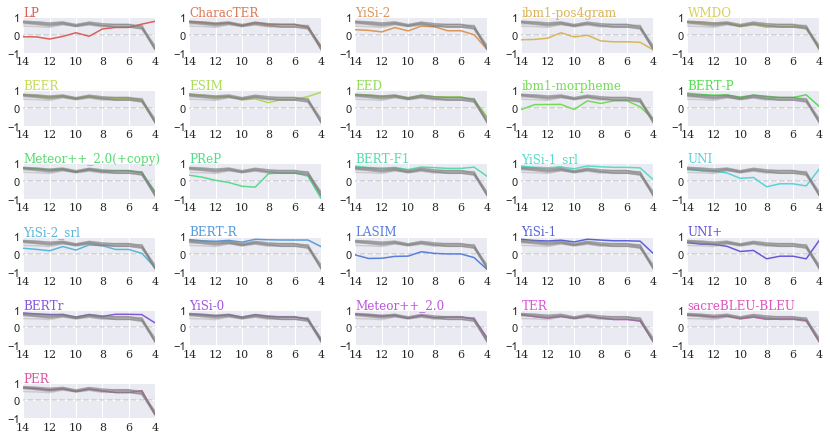

In [77]:
import warnings
warnings.filterwarnings("ignore")
# use LaTeX fonts in the plot
import matplotlib
matplotlib.rc('font', family='serif')

# for lp, top_n in lp_top_n['de-en']:
lp = 'de-en'
top_n = lp_top_n['de-en']
    
baselines = ['BLEU', 'NIST', 'TER', 'WER', 'PER', 'CDER', 'chrF', 'chrF+', 'sacreBLEU-BLEU', 'sacreBLEU-chrF']
draw_baselines = ['sacreBLEU-BLEU', 'NIST', 'sacreBLEU-chrF', 'PER', 'TER']
ignores = ['DA', 'rank']
num_participants = len(top_n.columns) + len(draw_baselines) - len(baselines) - len(ignores)

#A4
plt.style.use('seaborn-darkgrid')
FIGSIZE = (11.69, 6.27)
plt.figure(figsize=FIGSIZE)
palette = sns.color_palette('hls', num_participants)

# general title
# plt.suptitle(lp, fontsize=15)
# plt.gcf().text(0.5, 0.00, '# of systems (sorted ascending)', ha='center', va='center')
# plt.gcf().text(0.00, 0.5, 'Pearson\'s $r$', ha='center', va='center', rotation='vertical')

i = 0
print(lp)
for column in top_n.columns:
    if i > 25:
        break

    # plot only participants
    if (column in baselines or column in ignores) and column not in draw_baselines:
        continue

    i += 1
    plt.subplot(6, 5, i)


    # same limits for everybody
    plt.xlim(4, len(top_n))
    plt.ylim(-1, 1)
    plt.xticks(list(range(4, len(top_n), 2)) + [len(top_n) ], fontfamily='serif' )      # add limit ticks

    plt.gca().invert_xaxis()
    plt.hlines(0, 0, 50, color='grey', alpha=0.3, linestyles='dashed')

    # plots
    plt.plot(top_n['rank'], top_n[column], color=palette[i-1])
    for baseline in baselines:
        plt.plot(top_n['rank'], top_n[baseline], color='grey', alpha=0.3)

    # Not ticks everywhere
    if i < num_participants-4:
        plt.tick_params(labelbottom='off')
    if i not in [1,6,11,16,21] :
        plt.tick_params(labelleft='off')

    if column == 'Meteor++_2.0(syntax)':
        column = 'Meteor++_2.0'
    elif column == 'Meteor++_2.0(syntax+copy)':
        column = 'Meteor++_2.0(+copy)'
    # Add title
    plt.title(column, loc='left', pad=1, fontfamily='serif', color=palette[i-1])
    plt.tight_layout()

# save fig
plt.savefig('top_n/%s.pdf' % lp, bbox_inches='tight', pad_inches=0)

In [60]:
# by Ondrej's request
df.to_csv('sys-level_scores_metrics.csv')

### doc-level baselines

In [ ]:
doc_baseline_scores = pd.read_csv(gzip.open(os.path.join(WMT19_ROOT, 'baselines/mteval-inter.doc.score.gz'), 'rt'), delimiter=' ', header=None)
doc_baseline_scores.columns = ['metric', 'lp', 'testset', 'docid', 'system', 'score']

doc_baseline_scores = pd.merge(doc_baseline_scores[doc_baseline_scores.metric == 'NIST'], doc_baseline_scores[doc_baseline_scores.metric == 'BLEU'],
                              on=['lp', 'testset', 'docid', 'system'])
doc_baseline_scores = doc_baseline_scores.drop(['metric_x', 'metric_y', 'testset'], axis=1)
doc_baseline_scores.columns = ['lp', 'system', 'docid', 'NIST', 'BLEU']

In [ ]:
# no testsuites
doc_baseline_scores_nots = doc_baseline_scores[~doc_baseline_scores.docid.str.contains('testsuite')]
print(len(doc_baseline_scores_nots))

### doc-level submissions that are averages

In [ ]:
doc_submission_scores_nots = seg_all_scores[~seg_all_scores.docid.str.contains('testsuite')].groupby(['lp', 'system', 'docid']).mean()
print(len(doc_submission_scores_nots))

In [ ]:
doc_all_scores = pd.merge(doc_submission_scores_nots, doc_baseline_scores_nots, on=['lp', 'system', 'docid'], how='outer')
doc_all_scores

In [ ]:
# check if all docs have bleu scores
print(doc_all_scores[doc_all_scores.BLEU.isna()])
doc_all_scores[doc_all_scores.BLEU.isna()]['system'].unique()

In [ ]:
df.groupby(['lp']).count()['DA']